# (ADA) Homework 1: Scoring the Language Model Olympics

---

By the end of this homework, we expect you to be able to:

- Load data and handle data using pandas;
- Navigate the documentation of Python packages by yourself;
- Filter and tidy up noisy real-world datasets;
- Aggregate your data in different (and hopefully helpful) ways;
- Create meaningful visualizations to analyze the data;
- Communicate your findings in a clear and concise manner

---

**Some rules**

- You are allowed to use any built-in Python library that comes with Anaconda. If you want to use an external library, you may do so, but must justify your choice.
- Make sure you use the data folder provided in the repository in read-only mode. (Or alternatively, be sure you don’t change any of the files.)
- For questions containing the /Discuss:/ prefix, answer not with code, but with a textual explanation (in markdown).
- Back up any hypotheses and claims with data, since this is an important aspect of the course.
- Please write all your comments in English, and use meaningful variable names in your code.
---

## Context

Context
AI is booming! Newspapers, influencers, and your relatives all agree that AI is important. But while almost everyone agrees that AI is the future, much is unclear about what that future looks like…

Freshly graduated from the EPFL, you are hired by the Swiss government to advise on a large-scale “AI integration” initiative code-named **"NEUTRALITY"** (Navigating Efficient Upgrades Through Robust Artificial Learning Integration Techniques Yearly). Convinced by the stunning progress in language modeling, the government would like to battle the growing shortages in the education sector by using LMs. Your job description: investigate which LMs might be best suited!

You are given the results of three LMs on the [“Massive Multitask Language Understanding (MMLU)”](https://arxiv.org/abs/2009.03300) dataset to compare. This famous dataset consists of 57 subjects with multiple-choice questions, covering diverse subjects like mathematics, computer science, history, and law. Most providers of state-of-the-art LMs use this dataset to showcase the versatility of their latest models. Unfortunately, Horta-Ribeiro, the intern responsible for collecting the results, didn’t take EPFL’s famous ADA course. As a result, the collected datasets are slightly corrupted.

### A very brief primer on Language Models
Language models (LMs) are sophisticated statistical models designed to understand and generate human-like text. At their core, LMs are trained to predict the most likely continuation of a given input text. For example, given the input "The cat sat on the," an LM might predict "mat" as a likely continuation.
LMs are trained on vast text samples from various sources, including books, websites, and social media. This extensive training allows them to capture patterns and relationships in language, enabling them to generate coherent and contextually appropriate text across a wide range of topics and styles.

While LMs can produce text that appears to be written by intelligent humans, it's important to note that their capabilities can diverge from human intelligence in unexpected ways. They may sometimes generate factually incorrect information or struggle with complex reasoning tasks.

Two key concepts in understanding LMs are:
1. **Tokens**: LMs process text using "tokens" rather than individual characters. Tokens can be words, parts of words, or punctuation marks. For example, the sentence "I love AI!" might be tokenized as ["I", "love", "AI", "!"]. Tokenization is the first step in both training and using an LM.
2. **Context**: The input text provided to an LM is called the "context." This context informs the model's predictions or generations. A longer or more specific context often leads to more accurate and relevant outputs.

[See: Wikipedia entry on language models](https://en.wikipedia.org/wiki/Large_language_model)

###  Files for this assignment
This assignment is divided into three tasks, each of which should bring you a step closer to providing a recommendation toward project NEUTRALITY’s objectives:

- **Task 1**: Inspecting the results and getting your first model ranking
- **Task 2**: Inspecting the underlying data used to generate the results for possible biases
- **Task 3**: Learning about tokens and providing a final recommendation


```
📁 PROJECT_NEUTRALITY
│
├── 📄 analysis.ipynb (the file you're currently reading!)
├── 📄 requirements.txt (install into your environment)
│
├── 📁 task_1
├── 📁 task_2
└── 📁 task_2.5
```   
 

In [42]:
# please make sure you install the packages listed in the requirements.txt file in your environment!
# using pip
# pip install -r requirements.txt
#
# using Conda:
# conda create --name <env_name> --file requirements.txt
#
# some basic imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from scipy.stats import ttest_ind

## Task 1 (18 points): What's in an average anyway?

The files needed to complete task 1 can be found in the folder "`data/task_1/`:
```
task_1/
│
├── mmlu_data/
│   └── test.csv
│
└── lm_scores/
    ├── lm_X.csv
    ├── lm_Y.csv
    └── lm_Z.csv
```

We will start by loading, (manually) inspecting, and cleaning the data. Although it doesn't seem "glamorous" (nor is it particularly fun...) - manually inspecting data is extremely important! In fact, it's one of the few things most AI and Data Science researchers agree on :). Next, we will take a first pass on ordering our Olympic podium between three LMs.

### 1.1 (1 pt)
 
Load the subfiles contained in the `mmlu_data` and `lm_scores` folders into separate dataframes:
- `df_test`
- `df_x`
- `df_y`
- `df_z`

for each, print their sizes.

In [43]:
df_X = pd.read_csv("task_1/lm_scores/lm_X.csv")
df_Y = pd.read_csv("task_1/lm_scores/lm_Y.csv")
df_Z = pd.read_csv("task_1/lm_scores/lm_Z.csv")

df_test = pd.read_csv("task_1/mmlu_data/test.csv")


In [44]:
print("The size of X is ", df_X.shape)

print("The size of Y is ", df_Y.shape)
print("The size of Z is ", df_Z.shape)
print("The size of test is ", df_test.shape)

The size of X is  (13882, 2)
The size of Y is  (13978, 2)
The size of Z is  (13923, 2)
The size of test is  (14042, 8)


### 1.2 (4 pt)
Unfortunately, LMs don't always output the format we want. In the column `result`, the value should be one of A, B, C, or D. 

A. For each of the LM score dataframes, use a `value_counts()` operation and print the results. 

B. /Discuss:/ Inspect the results and describe the types of answer formats you see. Besides the "expected" case, you should be able to find at least four unexpected formats.

In [45]:
# A
print("Lm_X counts : " , df_X['result'].value_counts())

print("Lm_Y counts : " , df_Y['result'].value_counts())

print("Lm_Z counts : " , df_Z['result'].value_counts())

Lm_X counts :  result
A                                                                                                                 2733
A                                                                                                                 1657
B                                                                                                                 1412
Answer: A                                                                                                         1398
C                                                                                                                 1134
                                                                                                                  ... 
judicial activism, so the answer is A                                                                                1
creating insurmountable obstacles to the founding of factions, so the answer is A                                    1
A congressperson who retir

In [46]:
# B
# one strategy to find different cases, is to add a column counting the number of characters
# then, sample repeatedly.
df_temp = pd.concat([df_X.copy(), df_Y.copy(), df_Z.copy()]).reset_index(drop=True)
df_temp['result_len'] = df_temp['result'].apply(lambda x: len(str(x)))
df_temp[['result', 'result_len']].sample(10)


,result,result_len
40030,D,1
36131,C,1
7857,A,2
33008,C,1
15292,B,1
947,D,1
17512,B,2
31437,B,1
2435,D,2
36290,C,1


### 1.3 (5 pt)
Oh oh... That doesn't look great. Simply dropping all invalid answers seems overly wasteful, yet fixing all of these looks like a mess! Instead, let's focus for now on fixing just those answers of length < 10 characters that require only a single `str.replace()` operation. 

For example, if the answer looks like `--A--`, we could fix this by using the following simple function:

```
def clean_answer(s, pattern='-'):
    return str(s).replace(pattern, '')

dirty_answer = '--A--'
clean_answer = clean_answer(dirty_answer)
```

A. Filter the three score dataframes to include only answers with less than 10 characters. Make a deep copy of the dataframes as you filter them.

B. Modify the `clean_answer()` example function to clean the answers in the filtered data frames using the `apply()` functionality. Finally, make sure **all remaining answers are one of `A, B, C, or D`.**

C. /Discuss:/ Compare the sizes of the original and filtered data frames. What do you see? Why might this be a problem?

In [23]:
# A
def clean_answer(s):
    s = s.replace(' ','') 
    s = s.replace('Answer:','')
    return s

for i in df_temp:
    
    if df_temp['result_len']<10 :

        df_temp_clean_data = clean_answer(df_temp['result'])

        


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [47]:
def clean_answer(s):
    s = s.replace(' ','') 
    s = s.replace('Answer:','')
    return s

original_lens = []
filtered_lens = []
dfs = [] 
for df in [df_X, df_Y, df_Z]:
    # store original lengths for question C
    original_lens.append(len(df))
    
    df = df[df['result'].str.len() < 10].copy(deep=True)
    dfs.append(df)


In [48]:
# B
df_c = []
for df in dfs :
    df['result'] = df['result'].apply(lambda x : clean_answer(x))

    df = df[df['result'].isin(['A', 'B', 'C', 'D'])].copy(deep=True)
    df_c.append(df)
    filtered_lens.append(len(df))
    

for ol, fl, n in zip(original_lens, filtered_lens, ['X', 'Y', 'Z']):
    print(f'{n}: old = {ol}, filter = {fl} --> diff = {(fl - ol) / ol: .3f}')
    

X: old = 13882, filter = 13436 --> diff = -0.032
Y: old = 13978, filter = 13551 --> diff = -0.031
Z: old = 13923, filter = 12753 --> diff = -0.084


C. /Discuss:/

### 1.4 (3 pt)

Now that our answer columns are nicely formatted, let's take a look at model performance:

A. Both the `MMLU` dataframes and the language model score data frames have the columns `question_id`. For each of the language model score data frames, use an inner join operation with the `df_test` dataframe on the `question_id` column.

B. Add a new column to each of the resulting dataframes called `correct`, that checks if the model's answer in `result` is the same as the expected answer in the column `answer`. Then, print the average score of each model.

In [49]:
# B
dfs= []
for df in df_c:
    df = pd.merge(df, df_test,on = 'question_id', how = 'inner')
    dfs.append(df)

for df, n in zip(dfs, ['X', 'Y', 'Z']):
    df['correct'] = df['result'] == df['answer']
    print(f'{n}: {df["correct"].mean(): .3f}')

X:  0.767
Y:  0.746
Z:  0.663


### 1.5 (5 pt)

Hmmm, something doesn't seem quite right. Let's investigate how "balanced" this dataset is:

A. For each of the 57 subjects in the MMLU, compare the number of questions answered by each model. Print the subjects for which there is a more than 10% difference.

B. Propose and implement a reasonable way to rebalance the results. (e.g., while throwing away 100% of the results perfectly rebalances the results, it is not reasonable).

C. Finally, print the updated accuracy on the rebalanced data.

**hint:**:
- (A) For a given subject, let model X and model Y have answered 181 and 200 questions respectively. You can consider this a 10% difference from the perspective of X since: (200 - 181) / 181 > 0.10

In [50]:
# A
cats = df_test['subject'].unique()
cats10 = {}

for c in cats:
    temp = []
    for df in dfs:
        qs = len(df[df['subject'] == c])
        temp.append(qs)
    min_q = min(temp)
    max_q = max(temp)
    diff = (max_q - min_q) / min_q

    if diff > 0.10:
        cats10[c] = temp
        print(f'{c}'.ljust(30) + f'diff = {diff: .2f}')

college chemistry             diff =  0.17
college computer science      diff =  0.17
computer security             diff =  0.13
formal logic                  diff =  0.13
high school geography         diff =  0.11
logical fallacies             diff =  0.13
medical genetics              diff =  0.10
moral disputes                diff =  0.32
moral scenarios               diff =  0.17


In [51]:
# B
# one way of implementing this is to take the intersection of the different question_ids
qs = set()
for df in dfs:
    q_ = df['question_id'].unique()
    if len(qs) == 0:
        qs.update(q_)
    else:
        qs = qs.intersection(q_)

dfs_rebalance = []
for df in dfs:
    df = df[df['question_id'].isin(qs)].copy(deep=True)
    dfs_rebalance.append(df)

In [52]:
# C
for df, n in zip(dfs_rebalance, ['X', 'Y', 'Z']):
    print(f'\n{n}: {df["correct"].mean(): .3f}')


X:  0.767

Y:  0.747

Z:  0.662


## Task 2 (26 points): What do you mean A > D > B > C...?

Nice work! Having successfully inspected, cleaned, and rebalanced the provided data, you head over to director of the government's NEUTRALITY project. Ms. Sakota is happy with your work so far, but worried that the sloppy intern might have done more undetected damage. To be sure, she orders a new set of evaluations of all models on both MMLU and another dataset.

After cleaning up and rebalancing, you are left with the concatenated score files in the second folder `task_2`:
```
task_2/
│
└── lm_scores_mmlu.csv
│
└── lm_scores_other.csv
```

Each has a new column called `model_name`, which is one of `X, Y` or `Z`.



_NOTE: **only** use data from `task_2` and `task_2_5` for this assignment! The values in `lm_scores_mmlu.csv` will NOT be the same as the dataframes you finished in task 1. This is due to "randomness" or "temperature" in language model inference. This can slightly shift around generative results. (Conveniently: it also ensures any mistakes made in Task 1 don't propogate further ;) )_

In [53]:
# PROVIDED CODE
df_mmlu = pd.read_csv('task_2/lm_scores_mmlu.csv')
df_other = pd.read_csv('task_2/lm_scores_other.csv')

### 2.1 (4 pt)

Let's explore the new results:

A. Compute the mean accuracy and standard errors of each model on both datasets and print the results.

B. Then, show your results in a bar plot using standard errors with a 95% confidence interval around the mean. Make sure the plot is easy to read and well annotated.

C. /Discuss:/ the plot you created: (i) can you say that one of the models is the best? (ii) is there anything that seems odd?

  model_name dataset      mean       sem
0          X    mmlu  0.743588  0.004038
1          X   other  0.787976  0.006668
2          Y    mmlu  0.761542  0.003941
3          Y   other  0.720936  0.007317
4          Z    mmlu  0.655951  0.004393
5          Z   other  0.671721  0.007660


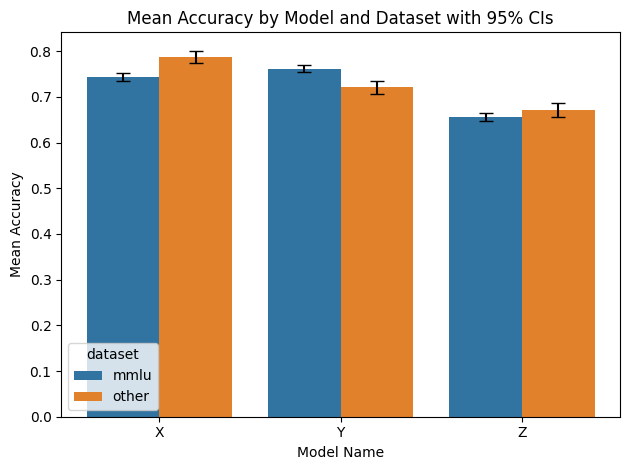

In [54]:
# A
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings

# Suppress the FutureWarning
warnings.filterwarnings("ignore", category=FutureWarning)

df_mmlu['dataset'] = 'mmlu'
df_other['dataset'] = 'other'
df = pd.concat([df_mmlu, df_other]).reset_index()

# Compute mean accuracy and standard errors
results = df.groupby(['model_name', 'dataset'])['correct'].agg(['mean', 'sem']).reset_index()
print(results)

ax = sns.barplot(x='model_name', y='mean', hue='dataset', data=results, errorbar=None)

# Add error bars manually
x_coords = np.arange(len(results['model_name'].unique()))
width = 0.4  # Adjust this value based on your bar width

for i, dataset in enumerate(['mmlu', 'other']):
    dataset_results = results[results['dataset'] == dataset]
    yerr = 1.96 * dataset_results['sem']  # 95% confidence interval
    plt.errorbar(x_coords + (i - 0.5) * width, dataset_results['mean'], 
                 yerr=yerr, fmt='none', c='black', capsize=5)

plt.title('Mean Accuracy by Model and Dataset with 95% CIs')
plt.xlabel('Model Name')
plt.ylabel('Mean Accuracy')
plt.tight_layout()
plt.show()

In [ ]:
# B

C. /Discuss:/

### 2.2 (5 pt)

Ms. Sakota has assured you that both datasets contain questions of similar difficulty, so, what could be going on here?

A. What is the distribution of correct answers (A, B, C, D) for each dataset? Create a bar chart to visualize this.

B. Perform a chi-square test at $\alpha = 0.05$, of independence to determine if there's a significant difference in the distribution of correct answers between the two datasets. What do you conclude?

**hints**:
- for (A), keep in mind that df_mmlu and df_other contain the results of all models, i.e., the `question_id` column is duplicated.
- for (A), take care to clearly annotate the bar chart, e.g., title, y-label, legend.
- for (B), clearly state the null hypothesis and alternative hypothesis
- use the `chi2_contingency` function from `scipy.stats`
- format your results from answer (A) as a 2D array

In [55]:
df_mmlu.head(60)

,result,question_id,question,A,B,C,D,answer,subject,correct,model_name,dataset
0,B,0,Find the degree for the given field extension ...,0,4,2,6,B,abstract algebra,True,X,mmlu
1,C,1,"Let p = (1, 2, 5, 4)(2, 3) in S_5 . Find the i...",8,2,24,120,C,abstract algebra,True,X,mmlu
2,D,2,Find all zeros in the indicated finite field o...,0,1,"0,1","0,4",D,abstract algebra,True,X,mmlu
3,B,3,Statement 1 | A factor group of a non-Abelian ...,"True, True","False, False","True, False","False, True",B,abstract algebra,True,X,mmlu
4,D,7,Statement 1 | A ring homomorphism is one to on...,"True, True","False, False","True, False","False, True",D,abstract algebra,True,X,mmlu
5,B,8,Find the degree for the given field extension ...,0,4,2,6,B,abstract algebra,True,X,mmlu
6,A,9,Find all zeros in the indicated finite field o...,1,2,"2,3",6,C,abstract algebra,False,X,mmlu
7,C,10,Statement 1 | If H is a subgroup of G and a be...,"True, True","False, False","True, False","False, True",C,abstract algebra,True,X,mmlu
8,C,11,"If A = {1, 2, 3} then relation S = {(1, 1), (2...",symmetric only,anti-symmetric only,both symmetric and anti-symmetric,an equivalence relation,C,abstract algebra,True,X,mmlu
9,C,13,The polynomial x^3 + 2x^2 + 2x + 1 can be fact...,(x − 2)(x + 2)(x − 1),(x + 1)(x + 4)(x − 2),(x + 1)(x − 4)(x − 2),(x - 1)(x − 4)(x − 2),C,abstract algebra,True,X,mmlu


answer
A    1611
B    2943
C    3403
D    3739
Name: count, dtype: int64 answer
A    1078
B    1116
C     924
D     641
Name: count, dtype: int64


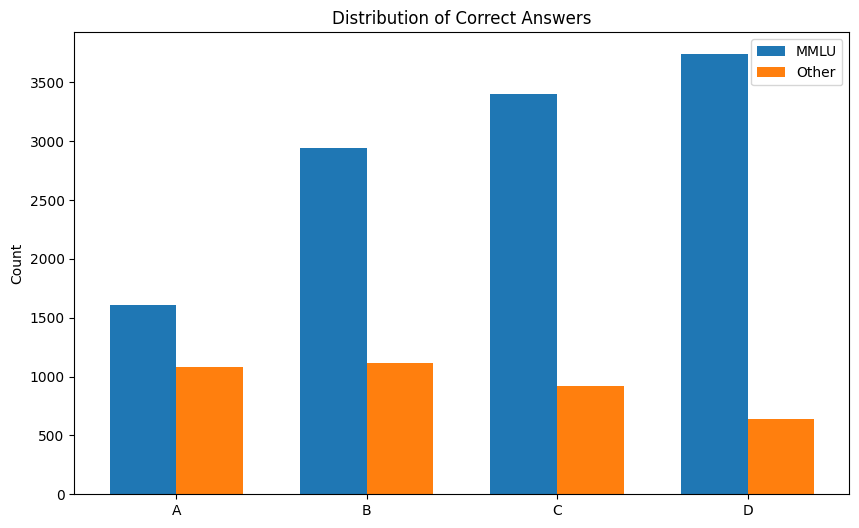

In [56]:
# A
from scipy.stats import chi2_contingency

correct_answers_1 = df_mmlu.drop_duplicates(subset=['question_id'])['answer']
correct_answers_2 = df_other.drop_duplicates(subset=['question_id'])['answer']

# Count the occurrences of each answer
count_1 = correct_answers_1.value_counts().sort_index()
count_2 = correct_answers_2.value_counts().sort_index()
print(count_1, count_2)

# Create a bar chart
fig, ax = plt.subplots(figsize=(10, 6))

x = range(len(count_1))
width = 0.35

ax.bar([i - width/2 for i in x], count_1, width, label='MMLU')
ax.bar([i + width/2 for i in x], count_2, width, label='Other')

ax.set_ylabel('Count')
ax.set_title('Distribution of Correct Answers')
ax.set_xticks(x)
ax.set_xticklabels(count_1.index)
ax.legend()

plt.show()



In [57]:
# B
contingency = pd.concat([count_1, count_2], axis=1).fillna(0)
chi2, p_value, _, _ = chi2_contingency(contingency)

# Interpret results
alpha = 0.05
if p_value <= alpha:
    print("Reject the null hypothesis.")
    print("There is a significant difference in the distribution of correct answers between the datasets.")
else:
    print("Fail to reject the null hypothesis.")
    print("There is not enough evidence to conclude a significant difference in the distribution of correct answers.")

Reject the null hypothesis.
There is a significant difference in the distribution of correct answers between the datasets.


### 2.3 (7 pt)

Let's dive in deeper:

A. What is language model X's mean accuracy conditioned on the four answer options for each dataset?

B. Compare LM X's performance when the correct answer is "A" between the two datasets. Use a T-test with CI = 0.95. What do you conclude?

C. Compare LM X's performance when the correct answer is "A" vs. "C or D" for each dataset. Use a T-test with CI = 0.95. What do you conclude?

In [ ]:
# A

In [ ]:
# B

In [ ]:
# C

### 2.4 (2 pt)

What an intriguing finding! 

A. Print the mean accuracies conditioned on the correct answer for all LMs for each dataset.

B. /Discuss:/ What do you observe?

In [ ]:
# A

B. /Discuss:/

### 2.5 (2 pt)

Concerned with your findings so far, you quickly consult with Ms. Sakota. After thinking it over, Ms. Sakota concludes that more tests are needed. She orders a second round of MMLU results. However, the clever Ms. Sakota thinks of the following twist: while keeping questions fixed, she randomly permutes the position of the correct answer. The new results can be found in the folder `data/task_2_5/`:
```
task_2_5/
│
└── lm_scores_mmlu_shuffle.csv
```

/Discuss:/ Why would Ms. Sakota do this?

/Discuss:/

### 2.6 (4 pt)

Increasingly sceptical of the language models' performance, you read up on proper testing practices. You stumble upon the concept of [test-rested stability](https://en.wikipedia.org/wiki/Repeatability), which roughtly states that:

"_Measurements taken by a single person or instrument on the same item, under the same conditions, and in a short period of time, should have the same results._"

In our case, we would assume an LM would have the same performance on a given question regardless of the correct answer position. One way of testing this is by using the following metric:

$$\text{test-retest metric} = \frac{1}{N}\sum_{i=1}^N \frac{1}{M}\sum_{j=1}^M c^i_0 c_j^i,$$

where $c^i_0 \in \{0, 1\}$ indicates whether the model answers the $i^{\text{th}}$ question correctly (1 if correct, 0 if incorrect). $c_j^i$ indicates whether the model answers the $i^{\text{th}}$ question correctly in the $j^{\text{th}}$ shuffled version of the answer label content. Finally, $M$ is the total number of shuffles and $N$ is the dataset size.

Task: compute the test-retest metric for each language model using the original `lm_scores_mmlu.csv` file and the new `lm_scores_mmlu_shuffle.csv` file. Using a bar plot, visualize your results by comparing the accuracy of the original `lm_scores_mmlu.csv` and the test-retest scores.

**hints**
- what is $M$ in our case?

(bonus: no points, but so much sweet, sweet knowledge - check out [the following article](https://arxiv.org/pdf/2406.19470v1))

### 2.7 (2 pt)

A. Using the unshuffled data: For each LM, print the distribution of the answers they give as well as the accuracy conditioned on the answer they give.

B. /Discuss:/ Describe what you observe

[bonus: not scored, but again _that sweet, sweet knowledge_] Could you think of a plausible explanation?

In [ ]:
# A

B. /Discuss:/

## Task 3 (16 points): What do Questions and Answers look like for a Language Model?

While you feel pretty good about the tests you conducted so far, something still bothers you: what if the language models don't see the data like you do? Suddenly, you receive a phone call from a wise AI sage in the West, _Westoda_:

```
"Hmm, correct you are, young padawan, to question how the world is seen by large language models! Simple 'text' it is not, hmm? No, no, no! Characters and words, the way of puny humans, this is not, heh heh heh.

'Tokens', they use, yes! Mysterious and powerful, these tokens are. Expand our vocabulary, they do, beyond the simple 'a to Z'. Chunky blocks of text, they become, yes! 'Hello world', a simple phrase it may seem. But to a language model, '[24912, 2375]' it might appear, yes! Confusing, it is, hmm?

Wise, it would be, to explore these MMLU data points through the eyes of a language model, you think? Yes, yes! Much to learn, there is. The ways of the tokens, understand you must, if truly comprehend the great LMs, you wish to.
Meditate on this, you should. The force of natural language processing, strong it is. But patience, you must have, my young padawan. For only through great study and contemplation, will the mysteries of the tokens reveal themselves to you, they will. Yes, hmmm!"
```

Admittingly, Westoda at times speaks in riddles… However, he was explaining a crucial aspect of modern LMs called [Tokenization](https://learn.microsoft.com/en-us/dotnet/ai/conceptual/understanding-tokens):


“Tokens are words, character sets, or combinations of words and punctuation that are used by [language models (LMs)] to decompose text into. Tokenization is the first step in training”

Instead of characters, LMs process natural language using “tokens”. While this is useful for a number of reasons, it does at times introduce some “unintuitive” behavior…

In [58]:
# PROVIDED CODE

try:
    import tiktoken
except Exception as e:
    print('installing tiktoken package')
    
    !pip install tiktoken
    
    import tiktoken

def tokenize_text(s):
    enc = tiktoken.encoding_for_model('gpt-4o')
    tokens = enc.encode(str(s))
    return tokens

example_string = 'hello world'
print(f'humans see: "{example_string}" --> language models see: {tokenize_text(example_string)}')

installing tiktoken package
   ---------------------------------------- 0.0/879.4 kB ? eta -:--:--
   ----------------------------------- ---- 786.4/879.4 kB 4.2 MB/s eta 0:00:01
   ---------------------------------------- 879.4/879.4 kB 3.6 MB/s  0:00:00

   ---------------------------------------- 0/2 [regex]
   -------------------- ------------------- 1/2 [tiktoken]
   ---------------------------------------- 2/2 [tiktoken]

humans see: "hello world" --> language models see: [24912, 2375]


### 3.1 (5 pt)

Use the provided code in the cell above to "see the world through the eyes of a language model":

A. Tokenize the questions of the original MMLU data provided in task 1: `task_1/mmlu_data/test.csv` and plot the token distribution (the frequency of each token).

B. Same as (A), but now for the answers in columns (columns "A", "B", "C", and "D").

C. Isolate the tokens for the strings "A", "B", "C", and "D", then, for their occurances in both questions and answers, print their relative distribution to each other.

**hint**
- There are a _lot_ of tokens, consider using a cutoff point and log scale
- For (c), they should sum to 1

In [71]:
# A
tokenize_df_test = []
tokenize_df_test=tokenize_text(df_test['question'])
tokenize_df_test

[15,
 309,
 9764,
 290,
 9882,
 395,
 290,
 4335,
 3259,
 15369,
 12646,
 16,
 309,
 9024,
 275,
 314,
 350,
 16,
 11,
 220,
 17,
 11,
 220,
 20,
 11,
 220,
 19,
 4898,
 17,
 11,
 220,
 18,
 8,
 306,
 336,
 62,
 20,
 887,
 9764,
 290,
 575,
 4908,
 17,
 309,
 9764,
 722,
 42274,
 306,
 290,
 26832,
 73104,
 3259,
 293,
 4908,
 18,
 309,
 32541,
 220,
 16,
 1022,
 355,
 12332,
 3566,
 328,
 261,
 2893,
 101885,
 126508,
 12646,
 19,
 309,
 9764,
 290,
 1888,
 328,
 290,
 4335,
 1823,
 174033,
 306,
 260,
 4908,
 15880,
 2550,
 35702,
 10165,
 2991,
 271,
 4614,
 853,
 1339,
 261,
 11082,
 5184,
 328,
 20159,
 9747,
 4908,
 10165,
 3150,
 257,
 2514,
 15904,
 2242,
 30633,
 30578,
 21446,
 3354,
 261,
 6517,
 4908,
 10165,
 3255,
 257,
 623,
 128531,
 2914,
 72557,
 784,
 2453,
 4748,
 1118,
 293,
 4908,
 10165,
 1723,
 271,
 16344,
 316,
 290,
 18938,
 12839,
 30022,
 11,
 1218,
 118263,
 4908,
 10165,
 4987,
 257,
 623,
 2269,
 262,
 328,
 156923,
 22653,
 316,
 1118,
 328,
 325,
 4908

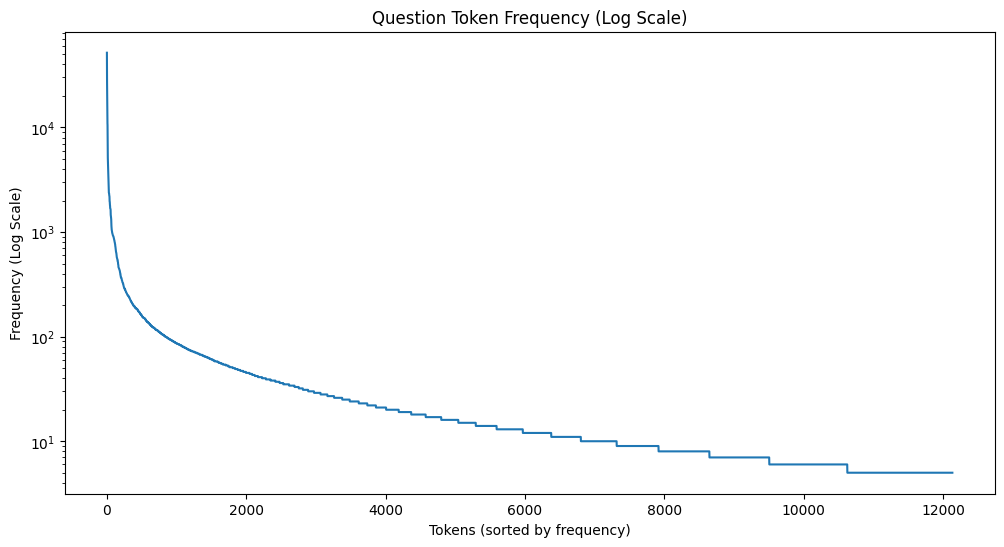

In [69]:
def plot_token_fequency(df, title, cutoff=5):
    filtered_counts = token_counts[token_counts >= cutoff]

    # Create a line plot
    plt.figure(figsize=(12, 6))
    sns.lineplot(x=range(len(filtered_counts)), y=filtered_counts.values)

    # Set log scale for y-axis
    plt.yscale('log')

    # Customize the plot
    plt.title(title)
    plt.xlabel('Tokens (sorted by frequency)')
    plt.ylabel('Frequency (Log Scale)')
    plt.show()

question_tokens = []
for q in df_test['question']:
    question_tokens.extend(tokenize_text(q))
    
df = pd.DataFrame({'token': question_tokens})
token_counts = df['token'].value_counts()
plot_token_fequency(df, 'Question Token Frequency (Log Scale)')


In [73]:
question_tokens

[11437,
 290,
 9882,
 395,
 290,
 4335,
 3259,
 15369,
 1486,
 1858,
 17629,
 7,
 17,
 936,
 44237,
 7,
 18,
 936,
 44237,
 7,
 1157,
 915,
 1072,
 1486,
 13,
 12845,
 275,
 314,
 350,
 16,
 11,
 220,
 17,
 11,
 220,
 20,
 11,
 220,
 19,
 4898,
 17,
 11,
 220,
 18,
 8,
 306,
 336,
 62,
 20,
 887,
 9764,
 290,
 3472,
 328,
 464,
 79,
 29,
 306,
 336,
 62,
 20,
 13,
 11437,
 722,
 42274,
 306,
 290,
 26832,
 73104,
 3259,
 328,
 290,
 4335,
 113464,
 483,
 76338,
 306,
 484,
 3259,
 13,
 1215,
 61,
 20,
 659,
 220,
 18,
 87,
 61,
 18,
 659,
 1215,
 61,
 17,
 659,
 220,
 17,
 87,
 306,
 1489,
 62,
 20,
 9900,
 220,
 16,
 1022,
 355,
 12332,
 3566,
 328,
 261,
 2893,
 101885,
 126508,
 3566,
 382,
 2893,
 101885,
 126508,
 13,
 32541,
 220,
 17,
 1022,
 1843,
 658,
 382,
 261,
 6078,
 185557,
 328,
 487,
 326,
 487,
 382,
 261,
 6078,
 185557,
 328,
 499,
 11,
 1815,
 658,
 382,
 261,
 6078,
 185557,
 328,
 499,
 13,
 11437,
 290,
 1888,
 328,
 290,
 4335,
 1823,
 174033,
 306,
 290,
 4335

In [ ]:
# B

In [ ]:
# C

### 3.2 (3 pt)

What if the number of "A", "B", "C", and "D" tokens in the question and answer pairs could influence a language model's decisions?

A. For each combined question-answers pair, compute: 
1. the number of "A", "B", "C", and "D" tokens; and
2. the total number of tokens.
3. then, group by the "correct" answer and compute the mean frequency of A, B, C, and D tokens and the total number of tokens. 
4. finally, print your results

B. /Discuss:/ What do you think of the hypothesis that the frequency of A, B, C, and D tokens could influence answers?


In [ ]:
# A

B. /Discuss:/

### 3.3 (4 pt)

Three of the most important considerations when deciding between language models are:

Quality
Costs
Speed

So far, much of your analysis has focused on quality. However, the government has indicated that they are quite concerned about both the total costs and speed as well. Specifically, it has been brought to their attention that a new `turbo` model has been launched! 

This model is both cheaper and faster than the models you evaluated so far. However, there is a catch: the context length* is much smaller than that of the other LMS. Namely, it can only process **300** tokens during inference. Meanwhile, the other models can process up to 100K tokens! 

*_The “context length” refers to the number of tokens that can be given to an LM as input._

A. Are there subjects where using the cheaper model might be problematic? I.e., where part of the question and answer(s) might not fit completely in the context?

B. /Discuss:/ Can you think of a strategy that would balance the needs of the government?

**hint**:
- An LM needs to have both the question and the different answer options in its context

In [ ]:
# A

B. /Dicsuss:/

### 3.4 (4 pt)

/Discuss:/ The time has come to give your final recommendation on the use of LMs in education to the government! Taking into account everything you analyzed in all the preceding tasks (1, 2, and 3), please write a short recommendation consisting of 4 bullet points discussing your concerns.

**hint**
- Try to use the MECE framework: _Mutually Exclusive Collectively Exhaustive_

/Discuss:/
1. 

2. 

3. 

4. 